In [62]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from glob import glob
import seaborn as sns
from PIL import Image

np.random.seed(42)
from sklearn.datasets import make_classification
from keras.utils.np_utils import to_categorical # used for converting labels to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, f1_score
from scipy import stats
from sklearn.preprocessing import LabelEncoder
import autokeras as ak

In [7]:
skin_df = pd.read_csv('siic-isic-224x224-images/train-71.csv')

In [8]:
INPUT_SIZE=32

In [9]:
skin_df.head(10)

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target
0,ISIC_0015719,IP_3075186,female,45.0,upper extremity,unknown,benign,0
1,ISIC_0052212,IP_2842074,female,50.0,lower extremity,nevus,benign,0
2,ISIC_0068279,IP_6890425,female,45.0,head/neck,unknown,benign,0
3,ISIC_0074268,IP_8723313,female,55.0,upper extremity,unknown,benign,0
4,ISIC_0074311,IP_2950485,female,40.0,lower extremity,unknown,benign,0
5,ISIC_0074542,IP_4698288,male,25.0,lower extremity,unknown,benign,0
6,ISIC_0075663,IP_6017204,female,35.0,torso,unknown,benign,0
7,ISIC_0075914,IP_7622888,male,30.0,torso,unknown,benign,0
8,ISIC_0076262,IP_5075533,female,50.0,lower extremity,unknown,benign,0
9,ISIC_0076545,IP_9802602,male,55.0,upper extremity,unknown,benign,0


In [10]:
# skin_df['sex'].unique()
item_counts = skin_df["diagnosis"].value_counts() # normalize=True for getting the percentage
item_counts

diagnosis
unknown     40
melanoma    20
nevus       11
Name: count, dtype: int64

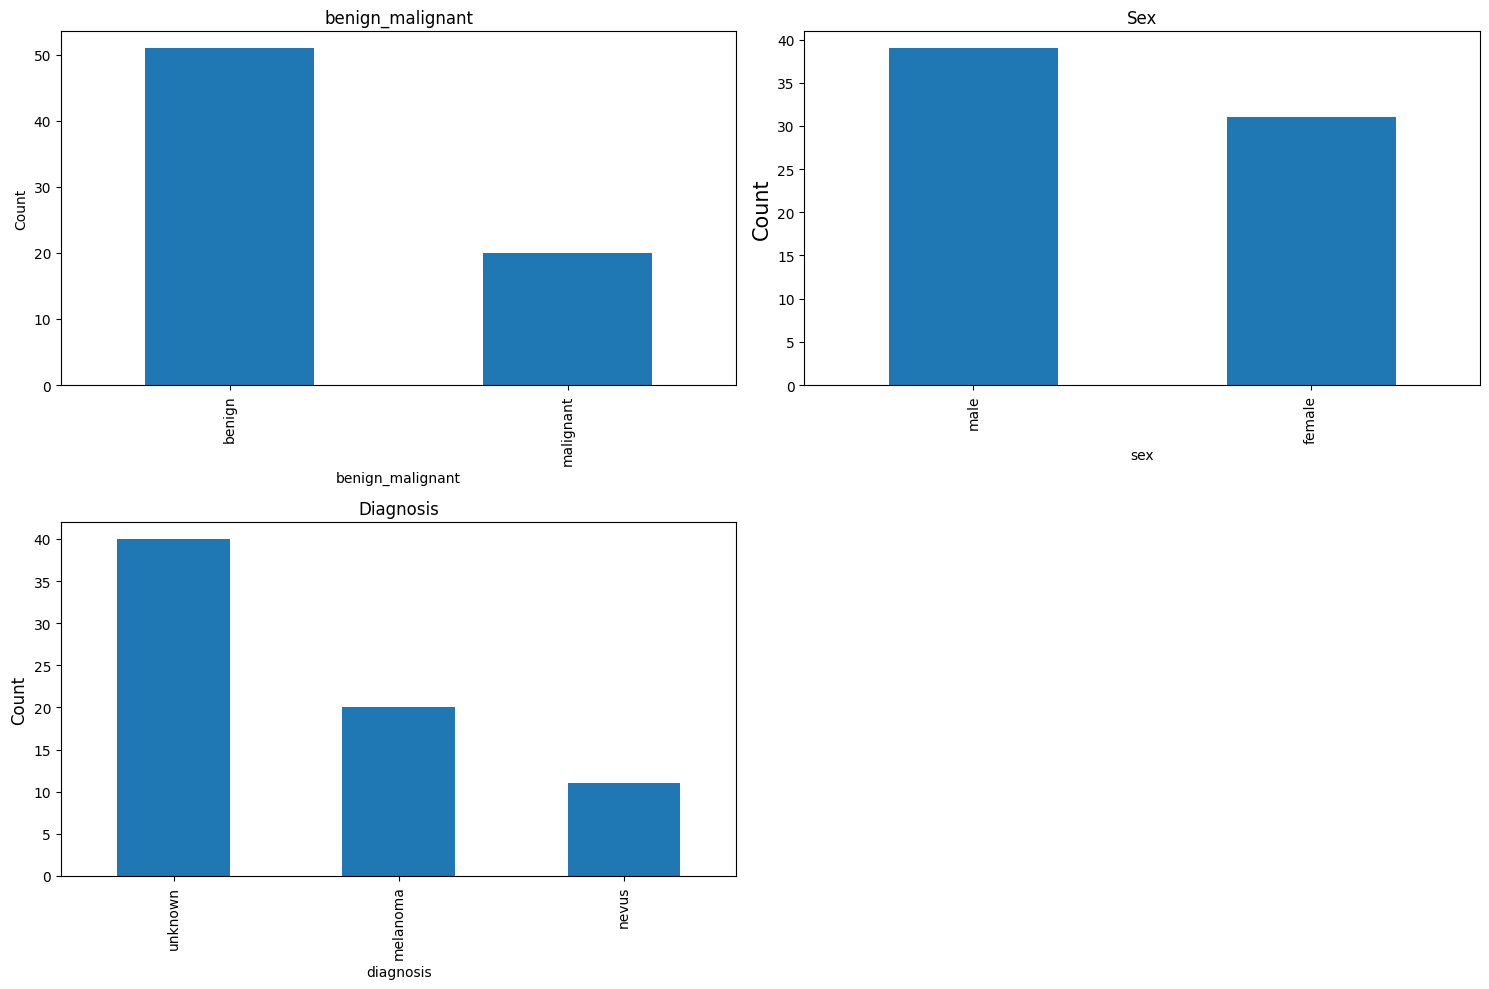

In [11]:
# Data distribution visualization
fig = plt.figure(figsize=(15,10))

ax1 = fig.add_subplot(221)
skin_df['benign_malignant'].value_counts().plot(kind='bar', ax=ax1)
ax1.set_ylabel('Count')
ax1.set_title('benign_malignant');

ax2 = fig.add_subplot(222)
skin_df['sex'].value_counts().plot(kind='bar', ax=ax2)
ax2.set_ylabel('Count', size=15)
ax2.set_title('Sex');

ax3 = fig.add_subplot(223)
skin_df['diagnosis'].value_counts().plot(kind='bar')
ax3.set_ylabel('Count',size=12)
ax3.set_title('Diagnosis')


# ax4 = fig.add_subplot(224)
# sample_age = skin_df[pd.notnull(skin_df['age'])]
# sns.distplot(sample_age['age_approx'], fit=stats.norm, color='red');
# ax4.set_title('Age')

plt.tight_layout()
plt.show()

In [12]:
# path = '/home/User/Desktop/file.txt'

# root_ext = os.path.splitext(path)
# root_ext

# path2 = '/home/User/Desktop/file.txt.sss'
# basename = os.path.basename(path2)
# basename

# aa = glob(os.path.join('siic-isic-224x224-images/train-71/', '*.png'))
# basename

In [13]:
image_path = {os.path.splitext(os.path.basename(x))[0]: x
                     for x in glob(os.path.join('siic-isic-224x224-images/train-71/', '*.png'))}

In [15]:
#Define the path and add as a new column
skin_df['image_path'] = skin_df['image_name'].map(image_path.get)
#Use the path to read images.
skin_df['image'] = skin_df['image_path'].map(lambda x: np.asarray(Image.open(x).resize((INPUT_SIZE,INPUT_SIZE))))

In [16]:
#Convert dataframe column of images into numpy array
X = np.asarray(skin_df['image'].tolist())
X = X/255.  # Scale values to 0-1. You can also used standardscaler or other scaling methods.
y = skin_df['target']  # Assign label values to Y
# Y_cat = to_categorical(y, num_classes=7) #Convert to categorical as this is a multiclass classification problem
#Split to training and testing
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [39]:
num_classes = 2

model = Sequential()
model.add(Conv2D(filters=32, kernel_size=(3, 3), activation="relu", input_shape=(INPUT_SIZE, INPUT_SIZE, 3)))
#model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))  
# model.add(Dropout(0.3))

model.add(Conv2D(64, (3, 3),activation='relu'))
#model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))  
# model.add(Dropout(0.3))

model.add(Conv2D(128, (3, 3),activation='relu'))
#model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))  
# model.add(Flatten())
model.add(Flatten())
model.add(Dropout(0.5))

# model.add(Dense(512, activation='relu'))
model.add(Dense(1, activation='sigmoid')) # Use Sigmoid instead of Softmax since Sigmoid is the proper activation function for binary data

model.summary()

model.compile(loss='binary_crossentropy', optimizer='Adam', metrics=['acc']) # Categorical Cross Entropy to Binary Cross Entropy since your output label is binary. 

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 15, 15, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (None, 13, 13, 64)        18496     
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 6, 6, 64)         0         
 g2D)                                                            
                                                                 
 conv2d_14 (Conv2D)          (None, 4, 4, 128)         73856     
                                                                 
 max_pooling2d_14 (MaxPoolin  (None, 2, 2, 128)       

In [40]:
# Train
#You can also use generator to use augmentation during training.

batch_size = 32
epochs = 25

history = model.fit(
    x_train, y_train,
    epochs = epochs,
    batch_size = batch_size,
    validation_data=(x_test, y_test),
    verbose=2)

score = model.evaluate(x_test, y_test)
print('Test accuracy:', score[1])

Epoch 1/25
2/2 - 2s - loss: 0.6905 - acc: 0.4906 - val_loss: 0.5947 - val_acc: 0.7778 - 2s/epoch - 981ms/step
Epoch 2/25
2/2 - 0s - loss: 0.6083 - acc: 0.6981 - val_loss: 0.5079 - val_acc: 0.7778 - 137ms/epoch - 68ms/step
Epoch 3/25
2/2 - 0s - loss: 0.5759 - acc: 0.6981 - val_loss: 0.4868 - val_acc: 0.7778 - 133ms/epoch - 67ms/step
Epoch 4/25
2/2 - 0s - loss: 0.6205 - acc: 0.6981 - val_loss: 0.4859 - val_acc: 0.7778 - 131ms/epoch - 65ms/step
Epoch 5/25
2/2 - 0s - loss: 0.5839 - acc: 0.6981 - val_loss: 0.4890 - val_acc: 0.7778 - 132ms/epoch - 66ms/step
Epoch 6/25
2/2 - 0s - loss: 0.5739 - acc: 0.6981 - val_loss: 0.5126 - val_acc: 0.7778 - 134ms/epoch - 67ms/step
Epoch 7/25
2/2 - 0s - loss: 0.5780 - acc: 0.6981 - val_loss: 0.5273 - val_acc: 0.7778 - 135ms/epoch - 68ms/step
Epoch 8/25
2/2 - 0s - loss: 0.5817 - acc: 0.6981 - val_loss: 0.5228 - val_acc: 0.7778 - 143ms/epoch - 71ms/step
Epoch 9/25
2/2 - 0s - loss: 0.5829 - acc: 0.6981 - val_loss: 0.5045 - val_acc: 0.7778 - 197ms/epoch - 98ms

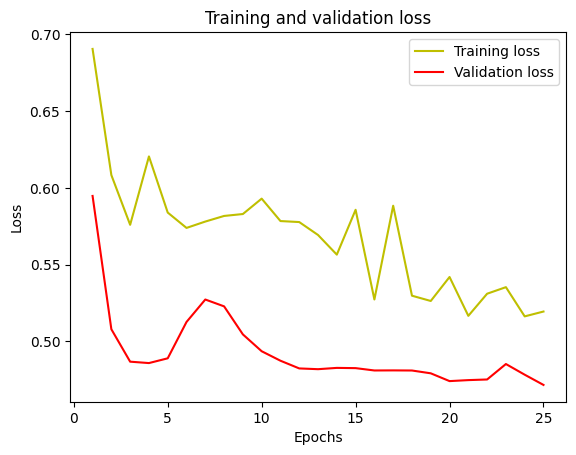

In [41]:
#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

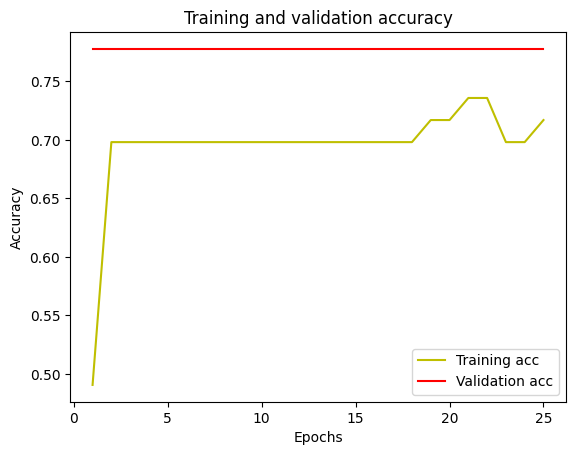

In [42]:
acc = history.history['acc']
val_acc = history.history['val_acc']
plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [52]:
p_pred = model.predict(x_test)
p_pred = p_pred.flatten()
print(p_pred.round(2))

1/1 [==============================] - 0s 57ms/step
[0.12 0.3  0.12 0.1  0.36 0.11 0.23 0.08 0.19 0.16 0.41 0.3  0.15 0.17
 0.26 0.08 0.25 0.08]


In [53]:
y_pred = np.where(p_pred > 0.5, 1, 0)
print(y_pred)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [54]:
print(confusion_matrix(y_test, y_pred))

[[14  0]
 [ 4  0]]


In [64]:
f1_score(y_test, y_pred,average='weighted',zero_division=0)

0.6805555555555557

In [59]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.78      1.00      0.88        14
           1       0.00      0.00      0.00         4

    accuracy                           0.78        18
   macro avg       0.39      0.50      0.44        18
weighted avg       0.60      0.78      0.68        18



/home/shuvo/Workstation/jupyterlab_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/shuvo/Workstation/jupyterlab_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/shuvo/Workstation/jupyterlab_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_